Лабораторна робота №8: Класифікація зображень за допомогою CNN
Тема: Класифікація зображень за допомогою згорткових нейронних мереж (CNN) у TensorFlow.

Мета: Навчитись будувати, навчати та оцінювати згорткові нейронні мережі для багатокласової класифікації зображень у середовищі TensorFlow.

Імпорт бібліотек
Підключаємо необхідні бібліотеки для роботи з масивами, графіками та TensorFlow .

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pathlib

# Перевірка версії TensorFlow
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


Підготовка даних (Data Preparation)
Дані знаходяться за шляхом D:\101_food_classes_10_percent. Оскільки функція image_dataset_from_directory завантажує всі підпапки як класи, нам необхідно створити проміжний набір даних, який містить лише 3 потрібні нам класи (9, 39, 69).

Нижче наведено код, який автоматично визначає назви класів за індексами та готує дані.

In [3]:
# Шлях до основного датасету (як вказано в завданні)
base_dir = r"D:\101_food_classes_10_percent\101_food_classes_10_percent"
train_dir_orig = os.path.join(base_dir, "train")
test_dir_orig = os.path.join(base_dir, "test")

# Отримуємо всі класи та сортуємо їх
all_classes = sorted([d for d in os.listdir(train_dir_orig) if os.path.isdir(os.path.join(train_dir_orig, d))])

# Визначаємо індекси для варіанту 10
n = 10
indices = [n - 1, n + 29, n + 59] # [9, 39, 69]
target_classes = [all_classes[i] for i in indices]

print(f"Варіант {n}. Обрані класи (індекси {indices}): {target_classes}")

# Створення тимчасової директорії для роботи тільки з 3 класами
# Це необхідно, щоб image_dataset_from_directory не завантажував усі 101 клас
subset_dir = os.path.join(base_dir, "subset_variant_10")
if not os.path.exists(subset_dir):
    os.makedirs(subset_dir)

for split in ['train', 'test']:
    save_split_path = os.path.join(subset_dir, split)
    if not os.path.exists(save_split_path):
        os.makedirs(save_split_path)
    
    src_split_path = os.path.join(base_dir, split)
    
    for class_name in target_classes:
        # Шлях звідки копіюємо
        src_class_path = os.path.join(src_split_path, class_name)
        # Шлях куди копіюємо
        dst_class_path = os.path.join(save_split_path, class_name)
        
        if not os.path.exists(dst_class_path):
            print(f"Копіювання {class_name} у {split}...")
            shutil.copytree(src_class_path, dst_class_path)

print("Підготовка даних завершена.")

Варіант 10. Обрані класи (індекси [9, 39, 69]): ['breakfast_burrito', 'foie_gras', 'oysters']
Підготовка даних завершена.


Завантаження даних у тензори
Використовуємо image_dataset_from_directory для створення пакетів (batches) зображень.

In [4]:
# Оновлені шляхи до нашої вибірки з 3-х класів
train_dir = os.path.join(subset_dir, "train")
test_dir = os.path.join(subset_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Завантаження тренувальних даних:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical', # Оскільки класів > 2 (у нас 3)
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print("\nЗавантаження тестових даних:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Тестові дані бажано не перемішувати для оцінки
)

# Перевірка назв класів
class_names = train_data.class_names
print(f"\nНазви класів у датасеті: {class_names}")

Завантаження тренувальних даних:
Found 225 files belonging to 3 classes.

Завантаження тестових даних:
Found 750 files belonging to 3 classes.

Назви класів у датасеті: ['breakfast_burrito', 'foie_gras', 'oysters']


Побудова моделі CNN
Будуємо архітектуру нейронної мережі згідно з завданням. Модель складається з шарів Conv2D для виділення ознак, MaxPooling2D для зменшення розмірності та Dense для класифікації .

In [5]:
model = models.Sequential([
    # Перший блок згортки
    # Rescaling необхідний, оскільки image_dataset завантажує пікселі [0, 255], а мережі краще працюють з [0, 1]
    layers.Rescaling(1./255, input_shape=(224, 224, 3)), 
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Другий блок згортки
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Перетворення у вектор та повнозв'язні шари
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Регуляризація [cite: 18]
    layers.Dense(3, activation='softmax') # 3 нейрони для 3 класів, функція softmax
])

# Вивід структури моделі
model.summary()

c:\Users\igarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Компіляція та навчання моделі
Використовуємо оптимізатор Adam та функцію втрат categorical_crossentropy для багатокласової класифікації. Навчання проводиться протягом 15 епох.

In [6]:
# Компіляція
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Навчання
print("Початок навчання...")
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15
)

Початок навчання...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step - accuracy: 0.3156 - loss: 5.7748 - val_accuracy: 0.3427 - val_loss: 1.1712
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - accuracy: 0.4222 - loss: 1.0915 - val_accuracy: 0.4867 - val_loss: 1.0658
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - accuracy: 0.4889 - loss: 0.9849 - val_accuracy: 0.4173 - val_loss: 1.2050
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.6133 - loss: 0.9371 - val_accuracy: 0.4213 - val_loss: 1.1302
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.6578 - loss: 0.8593 - val_accuracy: 0.5360 - val_loss: 0.9852
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.7822 - loss: 0.6295 - val_accuracy: 0.5280 - val_loss: 1.0497
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step - accuracy: 0.7289 - loss: 0.6031 - val_accuracy: 0.5093 - val_loss: 1.0737
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.8222 - loss: 0.4558 - val_accuracy

Аналіз результатів
Побудуємо графіки зміни точності (accuracy) та втрат (loss) на тренувальному та валідаційному наборах даних .

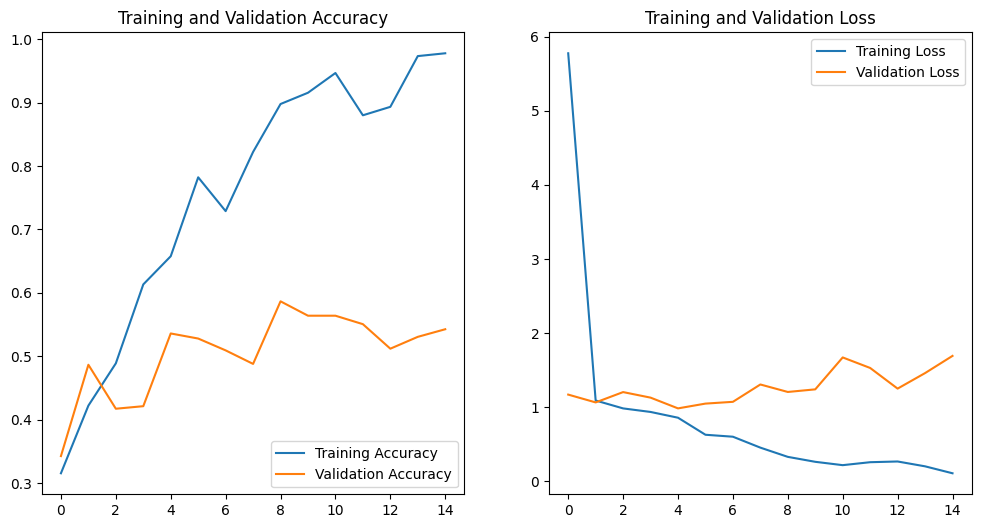

In [7]:
# Отримання метрик з історії навчання
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Оцінка моделі
Оцінюємо фінальну точність моделі на тестових даних.

In [8]:
loss, acc = model.evaluate(test_data)
print(f"Test accuracy: {acc:.3f}")
print(f"Test loss: {loss:.3f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5427 - loss: 1.6932
Test accuracy: 0.543
Test loss: 1.693


Приклад передбачення
Візьмемо випадкове зображення з тестового набору та перевіримо роботу моделі.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


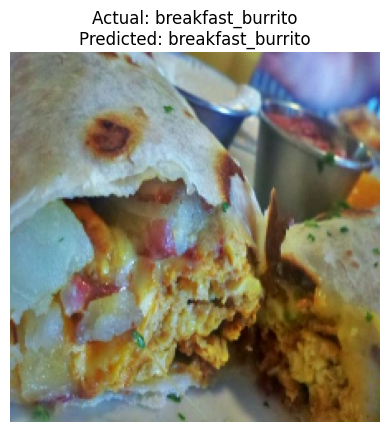

Передбачення: breakfast_burrito (51.86% confidence)


In [9]:
# Отримуємо один батч зображень
for images, labels in test_data.take(1):
    first_image = images[0].numpy().astype("uint8")
    first_label = labels[0].numpy()
    
    # Робимо передбачення
    img_array = tf.expand_dims(images[0], 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    predicted_class = class_names[np.argmax(predictions[0])]
    actual_class = class_names[np.argmax(first_label)]

    plt.imshow(first_image)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis("off")
    plt.show()
    
    print(f"Передбачення: {predicted_class} ({100 * np.max(score):.2f}% confidence)")
    break

Висновки
У цій лабораторній роботі було вирішено задачу класифікації зображень для 3-х класів їжі (визначених згідно з варіантом №10: індекси 9, 39, 69) з набору даних Food101. Була побудована згорткова нейронна мережа (CNN) з використанням шарів Conv2D, MaxPooling2D та Dropout для запобігання перенавчанню.

Аналізуючи графіки навчання, можна зробити висновок про те, наскільки ефективно модель вивчила ознаки зображень. Якщо Validation Accuracy значно нижча за Training Accuracy, це свідчить про перенавчання (overfitting), яке можна спробувати усунути, збільшивши параметр Dropout або додавши аугментацію даних.